In [17]:
# !pip3 install two-sample-binomial
# !pip3 install multiple-hypothesis-testing

from twosample import binom_test_two_sided
from multitest import MultiTest

import numpy as np
import scipy


import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['figure.figsize'] =  [8, 6]
mpl.style.use('ggplot')
%matplotlib inline
from tqdm import tqdm

from scipy.stats import poisson, binom, norm, hypergeom, uniform

import pandas as pd

from sample_survival_data import *

- Min HypGeom 
- Look for data.
    - SCANB ~ 3000 patients ~1000 unique time points
    - Keywords: dose response curve,
    - Perhaps survival of flies
- 

# Multiple Testing approach to Survival Analysis


Abstract

In some cases the log-rank test fails to detect the effect much more often than an approaoch based on mulitple testing. We present a survival model demonstrating this case, sating that events in each group follows a Poisson distribution with typical base rate $\lambda_1(t)$ and $\lambda_2(t)$, respectively. Usually, for most measurements, we have $\lambda_1(t) = \lambda_2(t)$, whereas sometimes $\lambda_2(t) > \lambda_1(t)$ (the effect is $\lambda_2(t) - \lambda_1(t)$ for those $t$ when this difference is not zero). The model is implemented in the function `sample_survival_data` in the file `sample_survival_data.py`. 

In this notebook, we use a specific parametrization of sparsity and signal intensity in numerical simulations to find cases where higher criticism and minP tests outperform log-rank. 

To do:
- Replace exact binomial test with exact hypergeometric test. This probably does not change the asymptotic behavior of the test but will likley have better power in practice. 
- Make a power analysis across a phase space, analytically and empirically.
- Derive the asymptotic power of the log-rank test under our model.

In [2]:
def log_rank_test(Nt1, Nt2):
    """
    log-rank test 
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    
    Returns:
    -------
    :z:       z score of the log-rank test
    :pvalue:  P-value
    """
    
    assert(len(Nt1) == len(Nt2))
    T = len(Nt1) - 1

    e0 = np.zeros(T)
    var0 = np.zeros(T)

    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    
    Nt = Nt2 + Nt1
    e0 = Nt1[:-1] * (Ot1 + Ot2) / Nt[:-1]
    var0 = e0 * ( (Nt[:-1] - (Ot1 + Ot2)) /  Nt[:-1]) * (Nt2[:-1] / (Nt[:-1] - 1))
    
    z = np.sum(Ot1 - e0) / np.sqrt(np.sum(var0))
    pval = 2*norm.cdf(-np.abs(z))
    return z, pval

$$
{\displaystyle E_{i,j}=N_{i,j}{\frac {O_{j}}{N_{j}}}}
$$
$$
{\displaystyle V_{i,j}=E_{i,j}\left({\frac {N_{j}-O_{j}}{N_{j}}}\right)\left({\frac {N_{j}-N_{i,j}}{N_{j}-1}}\right)}
$$

In [3]:
def hypergeom_test(k, M, n, N, alternative = 'greater', randomize=False):
    """
    Exact hypergeometric test
    
    Args:
    -----
    :k:    number of observed Type I objects
    :M:    total number of object
    :n:    total number of Type I objects
    :N:    number of draws
    :randomize:   whether to do a randomized test
    :alternative: type of alternative to consider. Options are: 
                  'greater', 'less', 'two-sided'
    
    """
    
    if randomize:
        U = uniform.rvs(size=len(k))
    else:
        U = 0
        
    if alternative=='greater':
        return hypergeom.sf(k, M, n, N) + U * hypergeom.pmf(k, M, n, N)
    if alternative=='less':
        return hypergeom.cdf(k-1, M, n, N) + U * hypergeom.pmf(k, M, n, N)
    raise ValueError("two-sided alternative is not available yet")

In [24]:
def q95(x):
    """
    Compute the 95-th percentile of the vector x
    """
    if x.dtypes.kind == 'O':
        return np.nan
    else:
        return pd.Series.quantile(x, .95)


In [25]:
def mutli_pvals(Nt1, Nt2):
    """
    Compute P-values from the pair list of coutns in the two group 
    We have one p-value per event time
    An even is a pair (Nt1[i], Nt2[i])
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    """
    
    assert(len(Nt1) == len(Nt2))
    
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    Nt = Nt2 + Nt1
    
    # binomial p-value; 
    # TODO: replace with a hypergeometric p-value
    # also have a one-sided version
    n = Ot1 + Ot2
    p = Nt2[:-1] / Nt[:-1]
    x = Ot2
    
    #pvals = binom_test_two_sided(x, n, p, randomize=True)  
    pvals = hypergeom_test(Ot2, Nt[:-1], Nt2[:-1], Ot1 + Ot2,
                           randomize=True, alternative='greater')
    return pvals


def mutli_pvals_binom(Nt1, Nt2):
    """
    Compute P-values from the pair list of coutns in the two group 
    We have one p-value per event time
    An even is a pair (Nt1[i], Nt2[i])
    
    Args:
    -----
    :Nt1:   vector of counts in group 1 (each count corresponds to an event)
    :Nt2:   vector of counts in group 2 
    """
    
    assert(len(Nt1) == len(Nt2))
    
    Ot1 = -np.diff(Nt1)
    Ot2 = -np.diff(Nt2)
    Nt = Nt2 + Nt1
    
    # binomial p-value; 
    # TODO: replace with a hypergeometric p-value
    # also have a one-sided version
    n = Ot1 + Ot2
    p = Nt2[:-1] / Nt[:-1]
    x = Ot2
    
    pvals = binom_test_two_sided(x, n, p, randomize=True)
    return pvals

In [26]:
def atmoic_experiment(T, N1, N2, eps, mu):
    """
    Sample from survival data; evalaute several test statistics
    
    Args:
    -----
    :T:    time horizon (~ total number of events)
    :N1:   total in group1 at t=0
    :N2:   total in group1 at t=0
    :eps:  fraction of non-null events
    :mu:   intensity of non-null events
    
    """
    
    Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
    return evaluate_test_stats(Nt1, Nt2)


def evaluate_test_stats(Nt1, Nt2):
    """
    Args:
    :Nt1: first list of events
    :Nt2: second list of events
    
    Compute several statistics of the two-sample data:
    log-rank
    higher criticism
    Fisher combination test
    minimum P-value
    Berk-Jones
    Wilcoxon ranksum
    """
    
    lr, lr_pval = log_rank_test(Nt1, Nt2)
    pvals = mutli_pvals(Nt1, Nt2)
    mt = MultiTest(pvals, stbl=False) # if not using stbl=False, then sometimes
                                      # HC misses the significance of the strongest effect 
    
    return {'Logrank': np.abs(lr),
            'HC': mt.hc()[0],
            'Fisher': mt.fisher()[0],
            'minP': mt.minp(),
            'BJ': mt.berk_jones(gamma=.45),
            'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue),
           }

## Sample once:

                BJ       Fisher        HC   Logrank       minP   wilcoxon
null_95q  6.911782  4071.702032  4.777988  1.960859  10.620356  14.365465
observed  5.273725  4009.634581  5.851688  1.498032  10.143416   9.815516
is_sig    0.000000     0.000000  1.000000  0.000000   0.000000   0.000000
-------------------------------------------------------------

Fliping roles of the lists:
                BJ       Fisher        HC   Logrank       minP   wilcoxon
null_95q  6.911782  4071.702032  4.777988  1.960859  10.620356  14.365465
observed  4.253643  4031.526977  1.708159  1.498032   6.154182   9.815516
is_sig    0.000000     0.000000  0.000000  0.000000   0.000000   0.000000


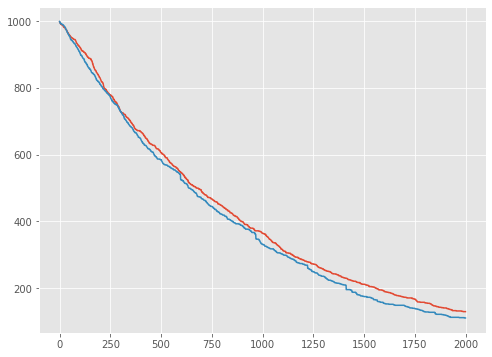

In [33]:
# single experiment non-null

T = 2000
N1 = N2 = 1000
beta = .7         # sparsity parameter
eps = np.round(T ** -beta,4)   # sparsity rate
mu = .02        # signal strength

Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)

lr, lr_pval = log_rank_test(Nt1, Nt2)
pvals = mutli_pvals(Nt1, Nt2)
mt = MultiTest(pvals, stbl=False)

df_null = pd.read_csv(f"under_null_T{T}_N{N1}.csv").drop('Unnamed: 0', axis=1)
r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher()[0],
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

print("-------------------------------------------------------------\n")
print("Fliping roles of the lists:")
lr, lr_pval = log_rank_test(Nt2, Nt1)

pvals = mutli_pvals(Nt2, Nt1)
mt = MultiTest(pvals, stbl=False)

df_null = pd.read_csv(f"under_null_T{T}_N{N1}.csv").drop('Unnamed: 0', axis=1)
r = {'Logrank': np.abs(lr),
'HC': mt.hc()[0],
'Fisher': mt.fisher()[0],
'minP': mt.minp(),
'BJ': mt.berk_jones(gamma=.45),
'wilcoxon': -np.log(scipy.stats.ranksums(Nt1, Nt2).pvalue)
    }

df_null['obs'] = 'null_95q'
rr = df_null.set_index('obs').append(pd.DataFrame(r, index=['observed']))
s = (rr.T['null_95q'] < rr.T['observed'])
s.name = 'is_sig'
print(rr.append(s))

tt = np.arange(T)
plt.plot(tt, Nt1[1:])
plt.plot(tt, Nt2[1:])
plt.show()
#pd.DataFrame({'N1' : Nt1, 'N2' : Nt2}).to_csv(f'surv_mu{mu}_eps{eps}.csv')


## Atomic experiment:

In [12]:
Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
evaluate_test_stats(Nt1, Nt2)

{'Logrank': 5.952263207723344,
 'HC': 134.11062194288294,
 'Fisher': 4234.682178177006,
 'minP': 17.089574035423794,
 'BJ': 14.508657620446826,
 'wilcoxon': 101.14994959179218}

## Many experiments

In [39]:
#params:
T = 1000     # number of event
N = N1 = N2 = 1500    # number in group 1 and 2 at t=0

### Null Behavior

In [115]:
# under null

from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

nMonte = 10000  #   number of experiments to evaluate dist. under null
df0 = pd.DataFrame()
for itr in tqdm(range(nMonte)):
    Nt1, Nt2 = sample_survival_data(T, N1, N2, 0, 0)
    res = evaluate_test_stats(Nt1, Nt2)
    df0 = df0.append(res, ignore_index=True)

# critical values under the null:
df0.agg([q95]).to_csv(f"under_null_T{T}_N{N1}.csv")
print(df0.agg([q95]))

100%|██████████| 10000/10000 [12:10<00:00, 13.70it/s]

           BJ      Fisher        HC   Logrank      minP   wilcoxon
q95  6.698572  2101.67351  4.439594  1.960672  9.753239  10.237862


### Non-Null Behavior

In [43]:
# under non-null

from twosample import binom_test_two_sided
from multitest import MultiTest
from typing import List

bb = np.linspace(.5, .9, 7)
rr = np.sqrt(np.linspace(0.01, 1, 9))
mm = 2 * rr * np.log(T) / N

df1 = pd.DataFrame()
nMonte = 100       # number of experiments

for itr in tqdm(range(nMonte)):
    for beta in bb:
        for mu in mm:
            eps = T ** -beta   # sparsity rate
            Nt1, Nt2 = sample_survival_data(T, N1, N2, eps, mu)
            res1 = evaluate_test_stats(Nt1, Nt2)
            res2 = evaluate_test_stats(Nt2, Nt1)
            res = pd.DataFrame(res1, index=[0])\
                    .join(pd.DataFrame(res2, index=[0]), rsuffix='2')
            res['mu'] = mu
            res['eps'] = eps
            res['beta'] = beta
            res['itr'] = itr
            df1 = df1.append(res, ignore_index=True)

100%|██████████| 100/100 [08:05<00:00,  4.85s/it]


In how many cases both the reversed and original sides were significant?

In [44]:
df_null = pd.read_csv(f"under_null_T{T}_N{N}.csv")
tests = ['Logrank', 'minP', 'HC', 'BJ', 'wilcoxon', 'Fisher']
for tsn in tests:
    tcrit = df_null[tsn].values[0]
    succ = (df1[tsn] > tcrit) & (df1[tsn + '2'] > tcrit)
    print(f"{tsn}: {np.mean(succ)} of cases")
    

Logrank: 0.5428571428571428 of cases
minP: 0.03841269841269841 of cases
HC: 0.039841269841269844 of cases
BJ: 0.04492063492063492 of cases
wilcoxon: 0.5096825396825397 of cases
Fisher: 0.004285714285714286 of cases


### Power Analysis:

Make sure to first find behavior under null with the selected $T$ and $N_1$ and $N_2$

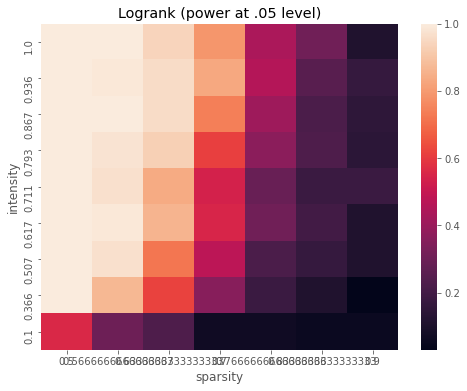

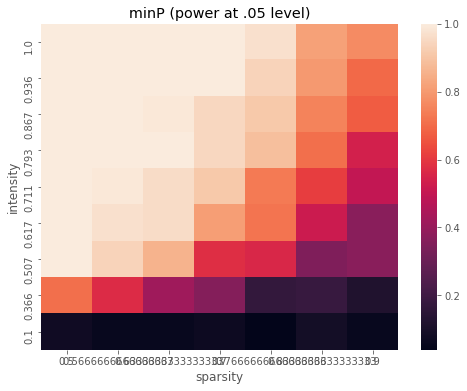

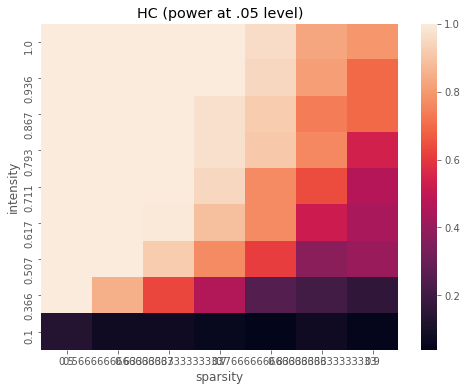

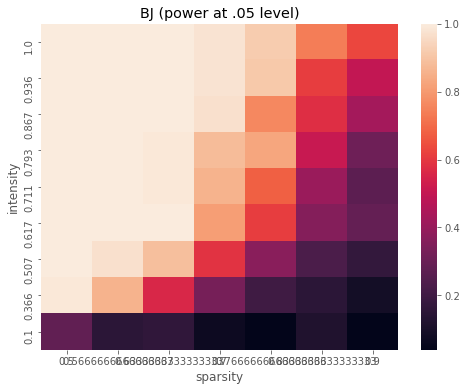

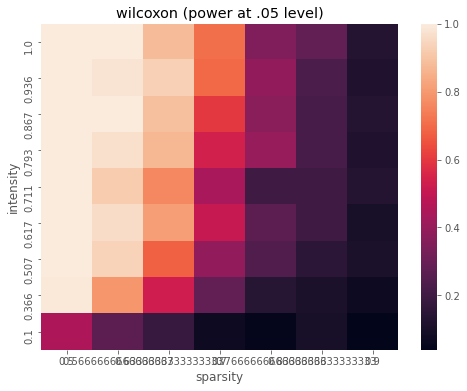

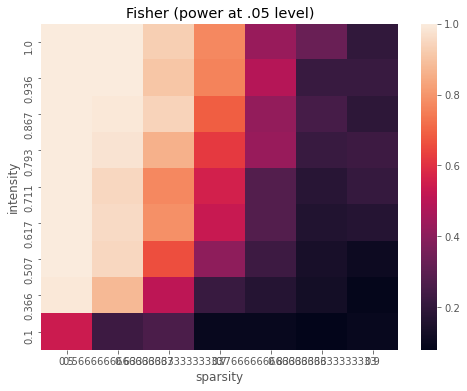

In [45]:
import seaborn 
tests = ['Logrank', 'minP', 'HC', 'BJ', 'wilcoxon', 'Fisher']

df_null = pd.read_csv(f"under_null_T{T}_N{N}.csv")

mat = np.zeros((len(bb), len(mm), len(tests)))

for k,tsn in enumerate(tests):
    for i,beta in enumerate(bb):
        for j,m in enumerate(mm):
            eps = T ** -beta   # sparsity rate
            dfc = df1[np.abs(df1.eps - eps) + np.abs(df1.mu - m) < 1e-10]
            tcrit = df_null[tsn].values[0]
            succ = dfc[tsn] > tcrit
            mat[i,j,k] = np.mean(succ)
         
    g = seaborn.heatmap(mat[:,::-1,k].T)
    #plt.imshow(mat[k]);
    plt.title(f"{tsn} (power at .05 level)")
    g.set_xticklabels(bb)
    g.set_xlabel('sparsity')
    g.set_ylabel('intensity')
    #g.set_yticklabels(np.round(mm[::-1],3))
    g.set_yticklabels(np.round(rr[::-1],3))
    plt.savefig(f"{tsn}.png")
    plt.show()



It makes sense intuitively that log-rank has power similar to Fisher and Wilcoxon, since all these tests known to have power against "dense" alternatives. 

In [7]:
import numpy as np
T = 1000
N = 1000

bb = np.linspace(.5, .9, 7)
rr = np.sqrt(np.linspace(0.01, 1, 9))
ss = np.sqrt(np.linspace(0.01, 1, 21))



len(np.meshgrid(bb, rr, ss))

3

In [13]:
import itertools

var_names = ['bb', 'rr', 'ss']

lol = [list(bb), list(rr), list(ss)]

a = list(itertools.product(*lol))[0]

In [18]:
results = pd.read_csv("results.csv")
results.head()

,Unnamed: 0,itr,T,N,beta,r,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,berk_jones_less,wilcoxon_less
0,0,1,2000,1000,0.45,0.0,-0.966026,-0.278955,3882.305386,6.638680,3.667096,0.002316,-0.966026,3.714860,4019.981041,9.821549,3.804533,6.068913e+00
1,1,1,2000,1000,0.45,0.1,0.327041,7.336461,4036.761535,11.622771,8.457753,1.539613,0.327041,2.470378,3962.211385,8.708610,5.363491,2.413891e-01
2,2,1,2000,1000,0.45,0.2,3.193003,2.228486,4144.567391,7.270281,5.628824,32.525553,3.193003,1.583695,3886.335800,9.053409,4.264150,7.438494e-15
3,3,1,2000,1000,0.45,0.3,3.231736,3.578665,4216.064631,8.512330,8.067953,24.876941,3.231736,2.208848,3996.059875,7.068894,3.728449,1.570655e-11
4,4,1,2000,1000,0.45,0.4,3.370846,3.802660,4208.758454,8.144684,6.208088,33.500661,3.370846,2.130312,3915.159645,9.128616,3.976292,2.775558e-15


In [20]:
df0 = results[results.r == 0]
df1 = results[results.r > 0]

In [28]:

df0.groupby().agg([q95])

,Unnamed: 0,T,N,beta,r,log_rank_greater,hc_greater,fisher_greater,min_p_greater,berk_jones_greater,wilcoxon_greater,log_rank_less,hc_less,fisher_less,min_p_less,berk_jones_less,wilcoxon_less
,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95,q95
itr,,,,,,,,,,,,,,,,,
1,74.1,2000,1000,0.935,0.0,0.368570,2.812417,4028.021696,9.241799,5.035035,1.167908,0.368570,3.348856,4133.607083,9.427363,4.018593,6.009662
2,165.1,2000,1000,0.935,0.0,0.842526,3.213415,4073.881718,9.742613,5.192047,6.387607,0.842526,3.152167,4079.153013,9.279153,4.357926,6.202666
3,256.1,2000,1000,0.935,0.0,0.945005,6.075213,4126.590406,10.748422,7.419128,6.469886,0.945005,2.474525,4137.863710,8.303595,5.586062,23.070366


In [30]:
params = ['itr', 'T', 'N', 'r', 'beta']
tests = ['log_rank', 'hc', 'min_p', 'berk_jones', 'wilcoxon', 'fisher']
tests = [c for c in df0.columns if c not in params and 'Unnamed' not in c]
tests

['log_rank_greater',
 'hc_greater',
 'fisher_greater',
 'min_p_greater',
 'berk_jones_greater',
 'wilcoxon_greater',
 'log_rank_less',
 'hc_less',
 'fisher_less',
 'min_p_less',
 'berk_jones_less',
 'wilcoxon_less']

In [32]:
(1-0.95)**2

0.0025000000000000044

In [ ]:

    
    



#def illustrate_phase_diagrams(df1, df0, out_filename='phase_diagram'):
"""

Args:
-----
:df1:   results from experiments under alternative 
:df0:   results from experiments under null
:out_filename:   file/path name to write to
"""

params = ['itr', 'T', 'N', 'r', 'beta']
tests = ['log_rank', 'hc', 'min_p', 'berk_jones', 'wilcoxon', 'fisher']
tests_vars = [c for c in df0.columns if c not in params and 'Unnamed' not in c]

global_params = ['T', 'N']



tcrit = df0.groupby(global_params).agg(q95)

good_side = 'greater'
bad_side = 'less'

for T in df1['T'].unique():
    for N in df1['N'].unique():
        df00 = df0[(df0['N'] == N) & (df0['T'] == T)]
        df11 = df1[(df1['N'] == N) & (df1['T'] == T)]
        
        print(f"Analyzing the case (N,T) = {(N,T)}")
        
        for tsn in tests:
            name_good = tsn + '_' + good_side
            name_bad = tsn + '_' + good_bad

            # we check rate when both sides succedds. These are not good outcomes
            two_side_succ = ( df1[name_good] > tcrit[name_good] ) & ( df1[name_bad] > tcrit[name_bad] )
            print(f"{tsn}: both sides detected in {np.mean(two_side_succ)} of cases")
            print("(you should be worried is this number is significantly larger than 0.05)")

            mat = np.zeros((len(bb), len(mm), len(tests)))

            for k,tsn in enumerate(tests):
                for i,beta in enumerate(bb):
                    for j,m in enumerate(mm):
                        eps = T ** -beta   # sparsity rate
                        dfc = df1[np.abs(df1.eps - eps) + np.abs(df1.mu - m) < 1e-10]
                        tcrit = df0[tsn].values[0]
                        succ = dfc[tsn] > tcrit
                        mat[i,j,k] = np.mean(succ)

                g = seaborn.heatmap(mat[:,::-1,k].T)
                plt.title(f"{tsn} (power at .05 level)")
                g.set_xticklabels(bb)
                g.set_xlabel('sparsity')
                g.set_ylabel('intensity')
                #g.set_yticklabels(np.round(mm[::-1],3))
                g.set_yticklabels(np.round(rr[::-1],3))
                fn = out_filename + tsn + ".png"
                plt.savefig(fn)
                plt.show()